In [105]:
import pandas as pd
import re
file = "transactions.csv"
df = pd.read_csv(file)
num = len(df)
print(f"Jumlah kolom: {num}")
print(df.head())

Jumlah kolom: 278932
                         transaction_id user_id  transaction_amount  \
0  4a71b7d1-34fa-45cf-b40a-a730d16ce617  U10578             23500.0   
1  b29665c0-8373-4ec1-a121-a041c77ffb51  U08353            150500.0   
2  3e32187b-b374-4f1b-a64e-b1ebcc856563  U04564             65800.0   
3  df8ad42e-aaf6-46d2-8d8f-1e291a4554bd  U22797             45600.0   
4  334468df-4d71-4e4a-935c-32c17c306611  U18053              8500.0   

  transaction_date merchant_id               merchant_name  \
0       2024-05-09      M04936                     Cox Inc   
1       2024-05-30      M06359      King, Rice and Ramirez   
2       2024-03-08      M01710  Lyons, Porter and Williams   
3       2024-05-14      M02852                   Smith Ltd   
4       2024-04-09      M00722                  Bush Group   

   merchant_category_id           geo_location payment_method  \
0                  5732  -7.974781, 112.633863        balance   
1                  5812  -6.188155, 106.817086   

In [24]:
mean_transaction_amount = df['transaction_amount'].mean()
min_transaction_amount = df['transaction_amount'].min()
median_transaction_amount = df['transaction_amount'].median()
max_transaction_amount = df['transaction_amount'].max()
print(f'Mean (Rata-rata) Transaction Amount: {mean_transaction_amount}')
print(f'Median Transaction Amount: {min_transaction_amount}')
print(f'Min Transaction Amount: {median_transaction_amount}')
print(f'Max Transaction Amount: {max_transaction_amount}')

Mean (Rata-rata) Transaction Amount: 500983.0137811366
Median Transaction Amount: 10000
Min Transaction Amount: 348000.0
Max Transaction Amount: 5871000


In [12]:
freq_df = df.groupby('user_id')['transaction_date'].count().reset_index(name='transaction_count')
freq_df['income_level'] = pd.cut(freq_df['transaction_count'], bins=[0, 5, 10, float('inf')],
                                 labels=['Low Income', 'Medium Income', 'High Income'])
print(freq_df.head())


  user_id  transaction_count   income_level
0  U00001                 11    High Income
1  U00002                 10  Medium Income
2  U00003                 11    High Income
3  U00004                  9  Medium Income
4  U00005                 10  Medium Income


Cek Missing Value dan Duplicated Data

In [11]:
print(df.isnull().sum())
print(f"Duplicate data :  {df.duplicated().sum()}")

transaction_id          0
user_id                 0
transaction_amount      0
transaction_date        0
merchant_id             0
merchant_name           0
merchant_category_id    0
geo_location            0
payment_method          0
user_agent              0
loyalty_program         0
discount_applied        0
promo_amount            0
transaction_notes       0
merchant_rating         0
transaction_status      0
is_refunded             0
dtype: int64
Duplicate data :  0


Ubah Transaction_date menjadi Hari

In [4]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'], format='%Y-%m-%d')
df['transaction_day'] = df['transaction_date'].dt.day_name()
print(df[['transaction_date', 'transaction_day']].head)

<bound method NDFrame.head of        transaction_date transaction_day
0            2024-05-09        Thursday
1            2024-05-30        Thursday
2            2024-03-08          Friday
3            2024-05-14         Tuesday
4            2024-04-09         Tuesday
...                 ...             ...
278927       2024-05-15       Wednesday
278928       2024-05-01       Wednesday
278929       2024-04-15          Monday
278930       2024-05-11        Saturday
278931       2024-05-10          Friday

[278932 rows x 2 columns]>


: 

In [4]:
unique_user_count = df['user_id'].nunique()
print(f"Total user_id unik: {unique_user_count}")

Total user_id unik: 24321


In [49]:
file = "transactions.csv"
df = pd.read_csv(file)
df['transaction_date'] = pd.to_datetime(df['transaction_date'], format='%Y-%m-%d')
df['transaction_month'] = df['transaction_date'].dt.to_period('M')  # Format YYYY-MM
df['transaction_day'] = df['transaction_date'].dt.day_name()

df['transaction_amount'] = df['transaction_amount'].fillna(0).astype(int) * 10

df['loyalty_program'] = df['loyalty_program'].map({'yes': True, 'no': False})

def educational_background(row):
    if row['payment_method'] == 'credit_card' and row['loyalty_program'] == True:
        return 'Good'
    elif row['payment_method'] == 'credit_card' or row['loyalty_program'] == True:
        return 'Moderate'
    else:
        return 'Low'

df['educational_background'] = df.apply(educational_background, axis=1)

def gender(transaction_count):
    return 'Female' if transaction_count > 11 else 'Male'

def income_level(row):
    if row['max_monthly_spending'] > 5000000:
        return 'high income'
    elif row['max_monthly_spending'] > 2500000:
        return 'medium income'
    else:
        return 'low income'

def age(user_agent):
    if 'Android' in user_agent:
        version_match = re.search(r'Android (\d+(\.\d+)?)', user_agent)
        if version_match and float(version_match.group(1)) < 10.0:
            return '>30'
        return '20 - 30'
    elif 'iPhone' in user_agent or 'iPad' in user_agent:
        version_match = re.search(r'OS (\d+(\_\d+)?)', user_agent)
        if version_match and float(version_match.group(1).replace('_', '.')) < 10:
            return '>30'
        return '20 - 30'
    return 'Unknown'

df['age'] = df['user_agent'].apply(age)

def marital_status(row):
    return 'Married' if row['total_amount'] > 5000000 and row['transaction_count'] > 11 else 'Single'

def parental_status(row):
    if row['total_amount'] > 7000000 and row['transaction_count'] > 11 and row['unique_merchants'] > 5:
        return 'As Parent' 
    else :'Non-Parents'

def get_user_locations(user_df):
    home_location = user_df[user_df['day_type'] == 'weekend'].groupby(['latitude', 'longitude']).size().idxmax()
    work_location = user_df[user_df['day_type'] == 'workday'].groupby(['latitude', 'longitude']).size().idxmax()
    return home_location, work_location

df['latitude'] = df['geo_location'].apply(lambda x: float(x.split(',')[0]))
df['longitude'] = df['geo_location'].apply(lambda x: float(x.split(',')[1]))

df['day_type'] = df['transaction_day'].apply(lambda x: 'weekend' if x in ['Saturday', 'Sunday'] else 'workday')

user_locations = {}
for user_id, user_data in df.groupby('user_id'):
    try:
        home_loc, work_loc = get_user_locations(user_data)
    except ValueError:  # Jika transaksi hanya di satu jenis hari
        home_loc, work_loc = (None, None)
    
    user_locations[user_id] = {
        'home_location': home_loc,
        'work_location': work_loc
    }
user_location_df = pd.DataFrame.from_dict(user_locations, orient='index', columns=['home_location', 'work_location']).reset_index()
user_location_df.columns = ['user_id', 'home_location', 'work_location']

def calculate_big_five_scores(df):
    refund_rates = df.groupby('user_id')['is_refunded'].apply(lambda x: (x == 'yes').mean()).to_dict()
    max_transaction_amount = df['transaction_amount'].max()
    
    scores = {'openness': [], 'conscientiousness': [], 'extraversion': [], 'agreeableness': [], 'neuroticism': []}
    
    for user_id, group in df.groupby('user_id'):
        openness = len(group['merchant_category_id'].unique()) / len(df['merchant_category_id'].unique())
        conscientiousness = (group['loyalty_program'] == True).mean()
        extraversion = group['transaction_amount'].sum() / max_transaction_amount
        agreeableness = (1 - refund_rates.get(user_id, 0)) * (group['merchant_rating'].mean() / 5)
        neuroticism = ((group['is_refunded'] == 'yes') | (group['merchant_rating'] < 3)).mean()

        scores['openness'].append((user_id, round(openness, 1)))
        scores['conscientiousness'].append((user_id, round(conscientiousness, 1)))
        scores['extraversion'].append((user_id, round(extraversion, 1)))
        scores['agreeableness'].append((user_id, round(agreeableness, 1)))
        scores['neuroticism'].append((user_id, round(neuroticism, 1)))

    return pd.DataFrame({
        'user_id': [x[0] for x in scores['openness']],
        'openness_score': [x[1] for x in scores['openness']],
        'conscientiousness_score': [x[1] for x in scores['conscientiousness']],
        'extraversion_score': [x[1] for x in scores['extraversion']],
        'agreeableness_score': [x[1] for x in scores['agreeableness']],
        'neuroticism_score': [x[1] for x in scores['neuroticism']]
    })

big_five_scores = calculate_big_five_scores(df)

user_summary = df.groupby('user_id').agg(
    total_amount=('transaction_amount', 'sum'),
    transaction_count=('transaction_amount', 'size'),
    avg_transaction=('transaction_amount', 'mean'),
    loyalty_used=('loyalty_program', 'mean')  # Rasio penggunaan loyalty program
).reset_index()

max_monthly_spending = df.groupby(['user_id', 'transaction_month'])['transaction_amount'].sum().groupby('user_id').max().reset_index()
max_monthly_spending.rename(columns={'transaction_amount': 'max_monthly_spending'}, inplace=True)
merchant_diversity = df.groupby('user_id')['merchant_id'].nunique().reset_index()
merchant_diversity.columns = ['user_id', 'unique_merchants']

# Gabungan semua informasi ke dalam user_summary
user_summary = pd.merge(user_summary, big_five_scores, on='user_id')
user_summary = pd.merge(user_summary, max_monthly_spending, on='user_id')
user_summary = pd.merge(user_summary, user_location_df, on='user_id')
user_summary = pd.merge(user_summary, merchant_diversity, on='user_id')

user_summary['gender'] = user_summary['transaction_count'].apply(gender)
user_summary['income_level'] = user_summary.apply(income_level, axis=1)
user_summary['marital_status'] = user_summary.apply(marital_status, axis=1)
user_summary['parental_status'] = user_summary.apply(parental_status, axis=1)

# Tampilkan hasil akhir
print(user_summary.head())



  user_id  total_amount  transaction_count  avg_transaction  loyalty_used  \
0  U00001       5146000                 11    467818.181818           0.0   
1  U00002       3645000                 10    364500.000000           0.0   
2  U00003      10079000                 11    916272.727273           1.0   
3  U00004       4308000                  9    478666.666667           0.0   
4  U00005       7952000                 10    795200.000000           0.0   

   max_monthly_spending            home_location            work_location  \
0               3952000  (-6.412503, 106.785043)  (-6.601615, 106.804172)   
1               2630000  (-7.260628, 112.746974)  (-7.969368, 112.625877)   
2               5326000  (-6.278574, 106.973935)  (-6.399603, 106.788439)   
3               2894000  (-6.596084, 106.803267)  (-6.274229, 106.990881)   
4               4537000  (-6.408683, 106.793823)  (-6.587412, 106.807738)   

   unique_merchants gender   income_level marital_status parental_status  

In [61]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['transaction_month'] = df['transaction_date'].dt.to_period('M')

monthly_spending = df.groupby(['user_id', 'transaction_month'])['transaction_amount'].sum().reset_index()

max_monthly_spending = monthly_spending.groupby('user_id')['transaction_amount'].max().reset_index()
max_monthly_spending = max_monthly_spending.rename(columns={'transaction_amount': 'max_monthly_spending'})

def working_status(row):
    return 'Employed' if row['max_monthly_spending'] > 3000000 else 'Non-Employed'


max_monthly_spending['working_status'] = max_monthly_spending.apply(working_status, axis=1)
print(max_monthly_spending.head())


  user_id  max_monthly_spending working_status
0  U00001              395200.0   Non-Employed
1  U00002              263000.0   Non-Employed
2  U00003              532600.0   Non-Employed
3  U00004              289400.0   Non-Employed
4  U00005              453700.0   Non-Employed


In [110]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['transaction_amount'] = df['transaction_amount'].fillna(0).astype(int) * 10
df['month'] = df['transaction_date'].dt.to_period('M')
monthly_expense = df.groupby(['user_id', 'month'])['transaction_amount'].sum().reset_index()
user_avg_spending = monthly_expense.groupby('user_id')['transaction_amount'].mean().reset_index()
user_avg_spending = user_avg_spending.rename(columns={'transaction_amount': 'avg_monthly_spending'})

def segment_homeownership(avg_spending):
    if avg_spending > 3000000:
        return 'Homeowner'
    elif avg_spending > 1500000:
        return 'Renter'
    else:
        return 'Living with Family'

user_avg_spending['homeownership'] = user_avg_spending['avg_monthly_spending'].apply(segment_homeownership)

max_monthly_spending = monthly_expense.groupby('user_id')['transaction_amount'].max().reset_index()
max_monthly_spending = max_monthly_spending.rename(columns={'transaction_amount': 'max_monthly_spending'})

def working_status(amount):
    return 'Employed' if amount > 1000000 else 'Non-Employed'

max_monthly_spending['working_status'] = max_monthly_spending['max_monthly_spending'].apply(working_status)

def monthly_health_status(amount):
    if amount > 5000000:
        return 'High Health Status'
    elif 2000000 <= amount <= 5000000:
        return 'Medium Health Status'
    else:
        return 'Low Health Status'

monthly_expense['health_status'] = monthly_expense['transaction_amount'].apply(monthly_health_status)

user_info = pd.merge(user_avg_spending[['user_id', 'homeownership']],
                     max_monthly_spending[['user_id', 'max_monthly_spending', 'working_status']],
                     on='user_id', how='left')

user_info = pd.merge(user_info, 
                     monthly_expense[['user_id', 'health_status']].drop_duplicates('user_id'), 
                     on='user_id', how='left')

print(user_info[['user_id', 'health_status', 'max_monthly_spending', 'working_status', 'homeownership']].sort_values(by='user_id').head())



  user_id       health_status  max_monthly_spending working_status  \
0  U00001  High Health Status              39520000       Employed   
1  U00002  High Health Status              26300000       Employed   
2  U00003  High Health Status              53260000       Employed   
3  U00004  High Health Status              28940000       Employed   
4  U00005  High Health Status              45370000       Employed   

  homeownership  
0     Homeowner  
1     Homeowner  
2     Homeowner  
3     Homeowner  
4     Homeowner  


In [71]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['month'] = df['transaction_date'].dt.to_period('M')
monthly_spending = df.groupby(['user_id', 'month'])['transaction_amount'].sum().reset_index()
max_monthly_spending = monthly_spending.groupby('user_id')['transaction_amount'].max().reset_index()
max_monthly_spending.rename(columns={'transaction_amount': 'max_monthly_spending'}, inplace=True)

def industry_of_employment(row):
    if row['max_monthly_spending'] > 5000000:
        return 'Finance/Consulting/Technology'
    elif row['max_monthly_spending'] > 2500000:
        return 'Healthcare/Education/Management'
    else:
        return 'Retail/Hospitality/Other'

max_monthly_spending['industry_of_employment'] = max_monthly_spending.apply(industry_of_employment, axis=1)
df = pd.merge(df, max_monthly_spending[['user_id', 'max_monthly_spending', 'industry_of_employment']], on='user_id', how='left')
print(df[['user_id', 'max_monthly_spending', 'industry_of_employment']].drop_duplicates().head())


  user_id  max_monthly_spending           industry_of_employment
0  U10578               3213000  Healthcare/Education/Management
1  U08353               4428000  Healthcare/Education/Management
2  U04564               2860000  Healthcare/Education/Management
3  U22797               1948000         Retail/Hospitality/Other
4  U18053               1089000         Retail/Hospitality/Other


In [115]:
file_path = 'updated_data2.xlsx'
df = pd.read_excel(file_path)

print("Kolom di updated_data2.xlsx:", df.columns)

# Rename kolom sesuai kebutuhan
df = df.rename(columns={
    'Column1': 'user_id',
    'Column2': 'home_location',
    'Column3': 'work_location'
})

print(df.head())

def has_different_locations(row):
    return row['home_location'] != row['work_location']

df['different_locations'] = df.apply(has_different_locations, axis=1)

vehicle_expense_threshold = 5000000

transactions_file = 'transactions.csv'
transactions_df = pd.read_csv(transactions_file)
transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'], errors='coerce')
transactions_df['month'] = transactions_df['transaction_date'].dt.to_period('M')
monthly_spending = transactions_df.groupby(['user_id', 'month'])['transaction_amount'].sum().reset_index()

avg_monthly_spending = monthly_spending.groupby('user_id')['transaction_amount'].mean().reset_index()
avg_monthly_spending.columns = ['user_id', 'monthly_spending']


df = df.merge(avg_monthly_spending, on='user_id', how='left')

def vehicle_ownership(row):
    if row['different_locations']:
        return 'Owns vehicle'
    elif row['monthly_spending'] > vehicle_expense_threshold:
        return 'Owns vehicle'
    else:
        return 'No vehicle'
    
df['vehicle_ownership'] = df.apply(vehicle_ownership, axis=1)
print(df[['user_id', 'home_location', 'work_location', 'different_locations', 
          'monthly_spending', 'vehicle_ownership']].head())

# df.to_excel('vehicle_ownership_results.xlsx', index=False)


Kolom di updated_data2.xlsx: Index(['Column1', 'Column2', 'Column3', 'home', 'work'], dtype='object')
   user_id  home_location  work_location                     home  \
0  user_id  home_location  work_location                     home   
1   U00001          Depok          Bogor  (-6.412503, 106.785043)   
2   U00002       Surabaya         Malang  (-7.260628, 112.746974)   
3   U00003         Bekasi          Depok  (-6.278574, 106.973935)   
4   U00004          Bogor         Bekasi  (-6.596084, 106.803267)   

                      work  
0                     work  
1  (-6.601615, 106.804172)  
2  (-7.969368, 112.625877)  
3  (-6.399603, 106.788439)  
4  (-6.274229, 106.990881)  
Kolom di transactions.csv: Index(['transaction_id', 'user_id', 'transaction_amount', 'transaction_date',
       'merchant_id', 'merchant_name', 'merchant_category_id', 'geo_location',
       'payment_method', 'user_agent', 'loyalty_program', 'discount_applied',
       'promo_amount', 'transaction_notes', 'me

User Segmentation

Classic Segmentation

In [102]:
file_path = "transactions.csv"
dff = pd.read_csv(file_path)

dff['transaction_date'] = pd.to_datetime(dff['transaction_date'])
dff['transaction_month'] = dff['transaction_date'].dt.to_period('M')  # Ekstrak bulan
dff['transaction_amount'] = pd.to_numeric(dff['transaction_amount'], errors='coerce').fillna(0)

avg_spending_per_user = dff.groupby('user_id')['transaction_amount'].mean().reset_index()
avg_spending_threshold = avg_spending_per_user['transaction_amount'].median()

avg_spending_per_user['spender_type'] = avg_spending_per_user['transaction_amount'].apply(
    lambda x: 'High Spender' if x > avg_spending_threshold else 'Low Spender'
)
dff = dff.merge(avg_spending_per_user[['user_id', 'spender_type']], on='user_id', how='left')
monthly_purchase_freq = dff.groupby(['user_id', 'transaction_month']).size().reset_index(name='purchase_frequency')
dff = dff.merge(monthly_purchase_freq, on=['user_id', 'transaction_month'], how='left')
merchant_type_per_user = dff.groupby('user_id')['merchant_category_id'].nunique().reset_index()
merchant_type_per_user['multiple_categories'] = merchant_type_per_user['merchant_category_id'].apply(
    lambda x: 1 if x > 1 else 0
)
dff = dff.merge(merchant_type_per_user[['user_id', 'multiple_categories']], on='user_id', how='left')

dff['discount_applied'] = pd.to_numeric(dff['discount_applied'], errors='coerce').fillna(0)
dff['is_bargain_hunter'] = dff['discount_applied'].apply(lambda x: 1 if x == 'yes' else 0)
dff['is_merchant_loyal'] = dff.groupby('user_id')['merchant_id'].transform(lambda x: x.nunique() == 1)
dff['is_refunded'] = pd.to_numeric(dff['is_refunded'], errors='coerce').fillna(0)
dff['refund_rate'] = dff.groupby('user_id')['is_refunded'].transform('mean')
total_transactions_per_user = dff.groupby('user_id').size().reset_index(name='total_transactions')
active_months_per_user = dff.groupby('user_id')['transaction_month'].nunique().reset_index(name='active_months')
activity_score = total_transactions_per_user.merge(active_months_per_user, on='user_id')
activity_score['activity_score'] = activity_score['total_transactions'] / activity_score['active_months']
dff = dff.merge(activity_score[['user_id', 'activity_score']], on='user_id', how='left')

print(dff[['user_id', 'spender_type', 'purchase_frequency', 'multiple_categories', 
           'is_bargain_hunter', 'is_merchant_loyal', 'refund_rate', 'activity_score']].head())


  user_id  spender_type  purchase_frequency  multiple_categories  \
0  U10578  High Spender                   4                    1   
1  U08353  High Spender                   4                    1   
2  U04564  High Spender                   3                    1   
3  U22797   Low Spender                   5                    1   
4  U18053   Low Spender                   5                    1   

   is_bargain_hunter  is_merchant_loyal  refund_rate  activity_score  
0                  0              False          0.0        3.666667  
1                  0              False          0.0        5.000000  
2                  0              False          0.0        3.666667  
3                  0              False          0.0        3.333333  
4                  0              False          0.0        3.000000  


RFM Analysis Segmentation

In [78]:

import datetime as dt
df = pd.read_csv('transactions.csv')

df['transaction_date'] = pd.to_datetime(df['transaction_date'])
now = dt.datetime.now()

rfm = df.groupby('user_id').agg({
    'transaction_date': lambda x: (now - x.max()).days,  # Recency
    'transaction_id': 'count',  # Frequency
    'transaction_amount': 'sum'  # Monetary
}).reset_index()
rfm.columns = ['user_id', 'recency', 'frequency', 'monetary']

rfm['R_Segment'] = pd.qcut(rfm['recency'], 4, labels=['1', '2', '3', '4']).astype(str)
rfm['F_Segment'] = pd.qcut(rfm['frequency'].rank(method='first'), 4, labels=['4', '3', '2', '1']).astype(str)
rfm['M_Segment'] = pd.qcut(rfm['monetary'], 4, labels=['4', '3', '2', '1']).astype(str)
rfm['RFM_Segment'] = rfm['R_Segment'] + rfm['F_Segment'] + rfm['M_Segment']

rfm['RFM_Score'] = rfm[['R_Segment', 'F_Segment', 'M_Segment']].astype(int).sum(axis=1)

print(rfm[['user_id', 'RFM_Segment', 'RFM_Score']].head())


  user_id RFM_Segment  RFM_Score
0  U00001         433         10
1  U00002         434         11
2  U00003         331          7
3  U00004         443         11
4  U00005         431          8


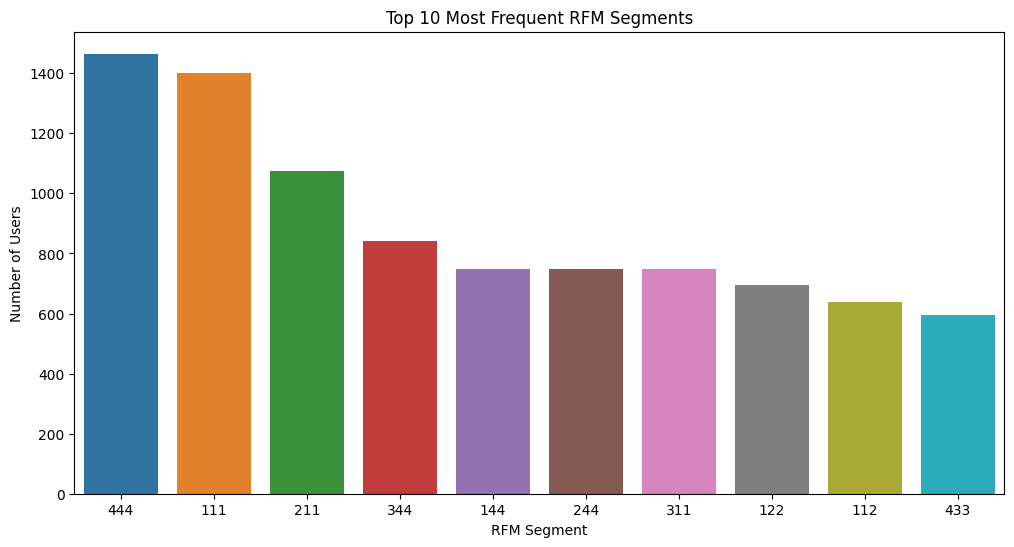

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting distribution of RFM Segments
plt.figure(figsize=(12,6))
rfm_segment_counts = rfm['RFM_Segment'].value_counts().head(10)  # Top 10 most frequent segments
sns.barplot(x=rfm_segment_counts.index, y=rfm_segment_counts.values)
plt.title('Top 10 Most Frequent RFM Segments')
plt.xlabel('RFM Segment')
plt.ylabel('Number of Users')
plt.show()


K-Means Clustering

user_id              0
transaction_count    0
total_amount         0
discount_usage       0
loyalty_member       0
dtype: int64
  user_id  transaction_count  total_amount  discount_usage  loyalty_member  \
0  U00001                 11      514600.0             0.0           False   
1  U00002                 10      364500.0             0.0           False   
2  U00003                 11     1007900.0             0.0            True   
3  U00004                  9      430800.0             0.0           False   
4  U00005                 10      795200.0             0.0           False   

   Cluster  
0        3  
1        0  
2        2  
3        0  
4        3  


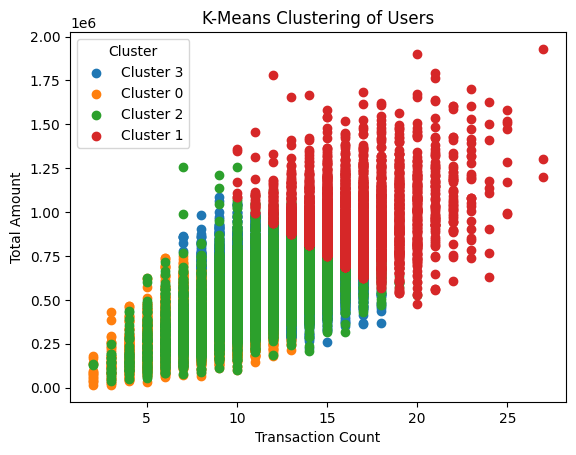

In [95]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

data = pd.read_csv('transactions.csv')

data['loyalty_program'] = data['loyalty_program'].map({'yes': True, 'no': False})
data['loyalty_program'] = data['loyalty_program'].fillna(False) 


user_data = data.groupby('user_id').agg({
    'transaction_id': 'count',  
    'transaction_amount': 'sum',
    'discount_applied': 'sum', 
    'loyalty_program': 'max'  
}).reset_index()
user_data.columns = ['user_id', 'transaction_count', 'total_amount', 'discount_usage', 'loyalty_member']

print(user_data.isna().sum())  # Periksa jumlah NaN di setiap kolom

user_data['transaction_count'] = pd.to_numeric(user_data['transaction_count'], errors='coerce')
user_data['total_amount'] = pd.to_numeric(user_data['total_amount'], errors='coerce')
user_data['discount_usage'] = pd.to_numeric(user_data['discount_usage'], errors='coerce')
user_data['loyalty_member'] = pd.to_numeric(user_data['loyalty_member'], errors='coerce')
user_data.fillna(0, inplace=True)
# Normalisasi data untuk K-Means
scaler = StandardScaler()
user_data_scaled = scaler.fit_transform(user_data[['transaction_count', 'total_amount', 'discount_usage', 'loyalty_member']])

kmeans = KMeans(n_clusters=4, random_state=42)
user_data['Cluster'] = kmeans.fit_predict(user_data_scaled)

print(user_data[['user_id', 'transaction_count', 'total_amount', 'discount_usage', 'loyalty_member', 'Cluster']].head())

for cluster in user_data['Cluster'].unique():
    cluster_data = user_data[user_data['Cluster'] == cluster]
    plt.scatter(cluster_data['transaction_count'], cluster_data['total_amount'], label=f'Cluster {cluster}')

# Tambahkan judul, label sumbu, dan legend
plt.title('K-Means Clustering of Users')
plt.xlabel('Transaction Count')
plt.ylabel('Total Amount')
plt.legend(title='Cluster')
plt.show()


Bargain Hunter

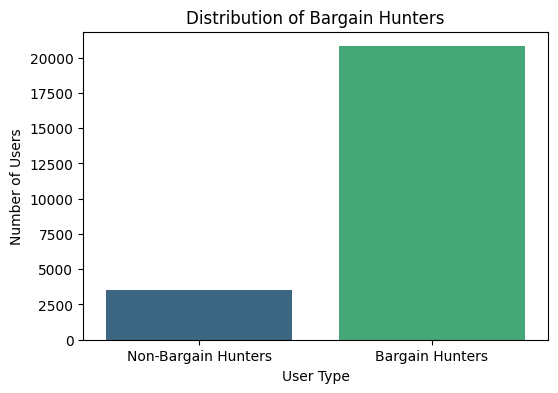

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "transactions.csv"
dff = pd.read_csv(file_path)

dff['is_bargain_hunter'] = dff['discount_applied'].apply(lambda x: 1 if x == 'yes' else 0)

bargain_hunters = dff.groupby('user_id')['is_bargain_hunter'].max().reset_index()
bargain_counts = bargain_hunters['is_bargain_hunter'].value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=bargain_counts.index, y=bargain_counts.values, palette='viridis')
plt.xticks([0, 1], ['Non-Bargain Hunters', 'Bargain Hunters'])
plt.title('Distribution of Bargain Hunters')
plt.ylabel('Number of Users')
plt.xlabel('User Type')
plt.show()


Spender Type

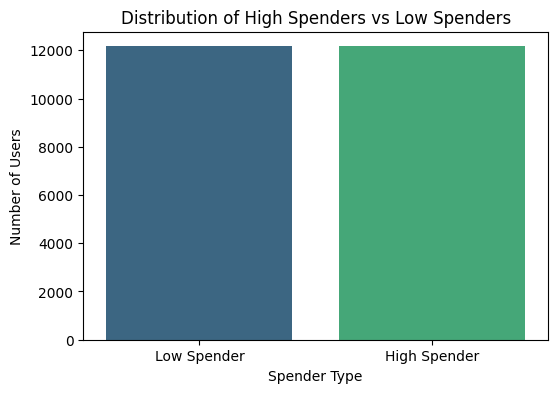

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "transactions.csv"
dff = pd.read_csv(file_path)

dff['transaction_amount'] = pd.to_numeric(dff['transaction_amount'], errors='coerce').fillna(0)

avg_spending_per_user = dff.groupby('user_id')['transaction_amount'].mean().reset_index()
avg_spending_threshold = avg_spending_per_user['transaction_amount'].median()

avg_spending_per_user['spender_type'] = avg_spending_per_user['transaction_amount'].apply(
    lambda x: 'High Spender' if x > avg_spending_threshold else 'Low Spender'
)

spender_counts = avg_spending_per_user['spender_type'].value_counts()

# 4. Plot hasil dengan bar plot
plt.figure(figsize=(6, 4))
sns.barplot(x=spender_counts.index, y=spender_counts.values, palette='viridis')
plt.title('Distribution of High Spenders vs Low Spenders')
plt.ylabel('Number of Users')
plt.xlabel('Spender Type')

# Tampilkan plot
plt.show()
